In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
def f(dev, a=30.19, b=-0.01744, c=39.47, d=0.0006516):
    return a * np.exp(b * dev) + c * np.exp(d * dev)

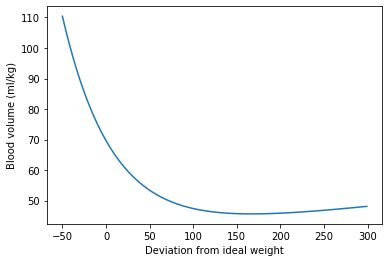

In [4]:
dev = np.arange(-50, 300)
plt.plot(dev, f(dev))
plt.xlabel('Deviation from ideal weight')
plt.ylabel('Blood volume (ml/kg)')
plt.show()

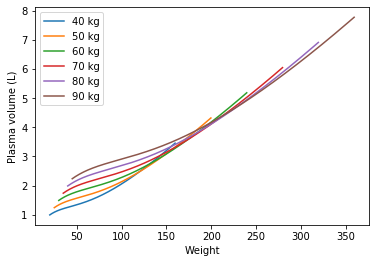

In [5]:
dev = np.arange(-50, 300)
hem = 0.45
for weight in (40, 50, 60, 70, 80, 90):
    plt.plot(weight * (1 + dev/100), hem * weight * (1 + dev/100) * f(dev) / 1000, label=f'{weight} kg')
plt.xlabel('Weight')
plt.ylabel('Plasma volume (L)')
plt.legend()
plt.show()

In [6]:
def g(Dev, A=1e10, h=1.6, ν=0.5, n=4, K=1, sex='male'):
    δ = Dev / 100
    if sex == 'male':
        a0, a1, a2 = 176.3, 220.6, 93.5
    elif sex == 'female':
        a0, a1, a2 = 145.8, 182.7, 79.55
    # height in m
    w_ideal = a0 + a1 * h + a2 * h**2
    return A * w_ideal ** ν * (1 + δ)**(n - 1) / ((K / w_ideal)**n + (w_ideal * (1 + δ))**n)

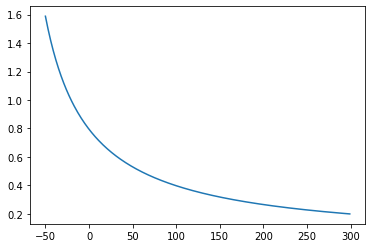

In [7]:
Dev = np.arange(-50, 300)
plt.plot(Dev, g(Dev))
plt.show()

In [8]:
#data = pd.read_csv('blood_volume_data.csv')
male_data = pd.read_csv('patient_data_male.csv')
female_data = pd.read_csv('patient_data_female.csv')

In [9]:
male_data['male'] = True
female_data['male'] = False
data = pd.concat([male_data, female_data])

In [10]:
def g(Dev, A=1e10, ν=0.5, n=4, K=1, male=data['male']):
    δ = Dev / 100.0
    result = np.zeros(len(Dev))
    w_ideal = np.zeros(len(Dev))
    
    #female = ~male
    #w_ideal[male] = 176.3 - 220.6 * h + 93.5 * h**2
    #w_ideal[female] = 145.8 - 182.7 * h + 79.55 * h**2
    #w_ideal = 176.3 + 220.6 * h + 93.5 * h**2
    
    # height in m
    partial = (np.exp(ν * np.log(w_ideal)) * np.exp((n - 1) * np.log(1 + δ)) /
               (np.exp(n * (np.log(K) - np.log(w_ideal))) + np.exp(n * (np.log(w_ideal) + np.log(1 + δ)))))
    return A * partial

In [11]:
def g(Dev, A=9e3, n=4, K=40):
    return A * ((100 + Dev)**(n-1) / ((100 + Dev)**n + (K)**n))

In [12]:
data

,div,bv,male
0,-25.344447,103.678010,True
1,-33.239472,102.335905,True
2,-31.250520,100.595333,True
3,-25.096225,99.764787,True
4,-39.365127,99.253387,True
...,...,...,...
75,104.040679,39.852484,False
76,105.730410,42.620090,False
77,165.604128,41.639442,False
78,209.642199,48.174021,False


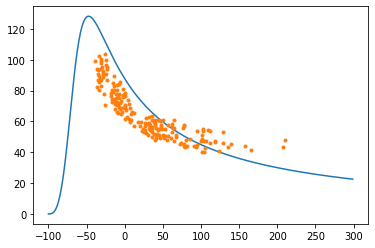

In [13]:
Dev = np.arange(-100, 300)
plt.plot(Dev, g(Dev))
plt.plot(data['div'], data['bv'], '.')
plt.show()

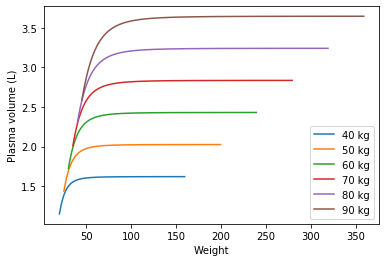

In [14]:
dev = np.arange(-50, 300)
hem = 0.45
for weight in (40, 50, 60, 70, 80, 90):
    plt.plot(weight * (1 + dev/100), hem * weight * (1 + dev/100) * g(dev) / 1000, label=f'{weight} kg')
plt.xlabel('Weight')
plt.ylabel('Plasma volume (L)')
plt.legend()
plt.show()

In [15]:
from scipy.optimize import curve_fit

In [16]:
?curve_fit

In [17]:
fit = curve_fit(g, data['div'], data['bv'], p0=[9e3, 4, 30],
                bounds=([0, 0, 0], [np.inf, 10, 100]), maxfev=3000)
params, cov = fit

In [18]:
params

array([1.42634330e+04, 7.45964264e-01, 1.00000000e+02])

In [19]:
cov

array([[ 3.02293281e+07, -1.69312413e+03,  5.77613025e+05],
       [-1.69312413e+03,  9.67352305e-02, -3.23702686e+01],
       [ 5.77613025e+05, -3.23702686e+01,  1.10403739e+04]])

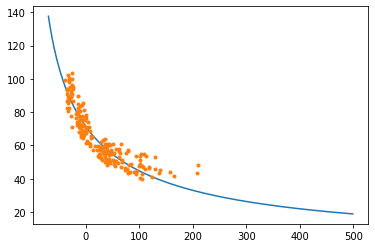

In [20]:
Dev = np.arange(-70, 500)
plt.plot(Dev, g(Dev, *params))
plt.plot(data['div'], data['bv'], '.')
plt.show()

In [21]:
def height(ideal_weight, sex='male'):
    if sex == 'male':
        c, b, a = 176.3 - ideal_weight, -220.6, 93.5
    elif sex =='female':
        c, b, a = 145.8 - ideal_weight, -182.7, 79.55
    #print(b**2 - 4*a*c)
    return (-b + np.sqrt(b**2 - 4*a*c)) / (2 * a)
        

In [22]:
height(80, 'male')

1.7810911160257792

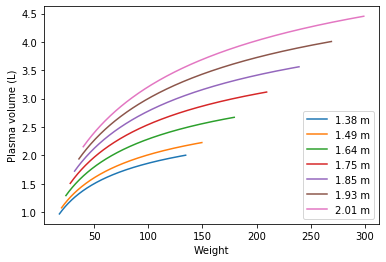

In [23]:
dev = np.arange(-60, 200)
hem = 0.45
for weight in (45, 50, 60, 70, 80, 90, 100):
    plt.plot(weight * (1 + dev/100), hem * weight * (1 + dev/100) * g(dev, *params) / 1000,
             label=f'{round(height(weight, sex="female"), 2)} m')
plt.xlabel('Weight')
plt.ylabel('Plasma volume (L)')
plt.legend()
plt.show()

In [24]:
params

array([1.42634330e+04, 7.45964264e-01, 1.00000000e+02])

In [25]:
cov

array([[ 3.02293281e+07, -1.69312413e+03,  5.77613025e+05],
       [-1.69312413e+03,  9.67352305e-02, -3.23702686e+01],
       [ 5.77613025e+05, -3.23702686e+01,  1.10403739e+04]])

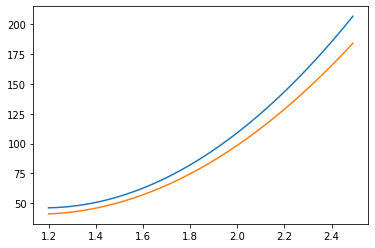

In [26]:
h = np.arange(1.2, 2.5, 0.01)
plt.plot(h, 176.3 - 220.6 * h + 93.5 * h**2)
plt.plot(h, 145.8 - 182.7 * h + 79.55 * h**2)

# New Vp formula

$\frac{Vp}{m} = a (100 + \mathrm{Dev})^{n-1}$

In [27]:
def g(Dev, A=100.0, n=4):
    return A * ((100 + Dev)**(n-1))

fit = curve_fit(g, data['div'], data['bv'], p0=[9e3, 4],
                bounds=([0, 0], [np.inf, np.inf]), maxfev=3000)
params, cov = fit

In [28]:
params

array([1.26975706e+03, 3.72981228e-01])

In [29]:
cov

array([[ 1.23055241e+04, -2.08576848e+00],
       [-2.08576848e+00,  3.55563867e-04]])

In [30]:
np.sqrt(cov)

/home/mauricio/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


array([[1.10930267e+02,            nan],
       [           nan, 1.88564012e-02]])

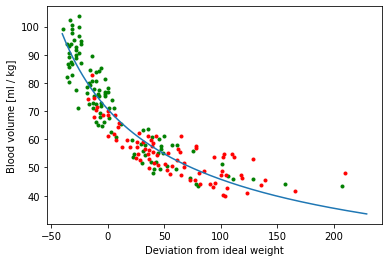

In [35]:
Dev = np.arange(-40, 230)

plt.plot(data['div'][data['male'] == True], data['bv'][data['male'] == True], '.', color='green')
plt.plot(data['div'][data['male'] == False], data['bv'][data['male'] == False], '.', color='red')
plt.plot(Dev, g(Dev, *params))
plt.xlabel('Deviation from ideal weight')
plt.ylabel('Blood volume [ml / kg]')
plt.savefig('Vp_fit.svg')
plt.show()

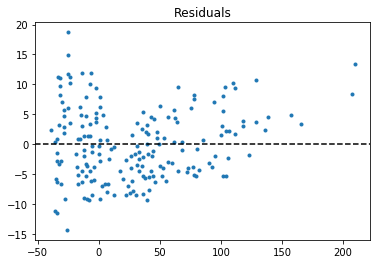

In [32]:
Dev = np.arange(-40, 230)
#plt.plot(Dev, g(Dev, *params))
plt.title("Residuals")
plt.plot(data['div'], data['bv'] - g(data['div'], *params), '.')
plt.axhline(0, color='black', linestyle='--')
plt.show()

/home/mauricio/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


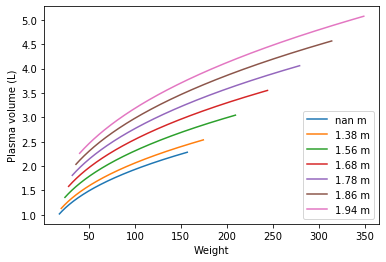

In [33]:
dev = np.arange(-60, 250)
hem = 0.45
for weight in (45, 50, 60, 70, 80, 90, 100):
    plt.plot(weight * (1 + dev/100), hem * weight * (1 + dev/100) * g(dev, *params) / 1000,
             label=f'{round(height(weight, sex="male"), 2)} m')
plt.xlabel('Weight')
plt.ylabel('Plasma volume (L)')
plt.legend()
plt.show()